In [1]:
import pandas as pd

In [2]:
data=pd.read_csv("dataset.csv",delimiter=";")

In [3]:
data=data[["estado","e3","e0"]]

In [4]:
data

,estado,e3,e0
0,R,0,0
1,R,0,0
2,R,0,0
3,R,0,0
4,R,0,0
...,...,...,...
462,A,1,1
463,A,1,1
464,A,1,1
465,A,1,1


<Axes: xlabel='estado'>

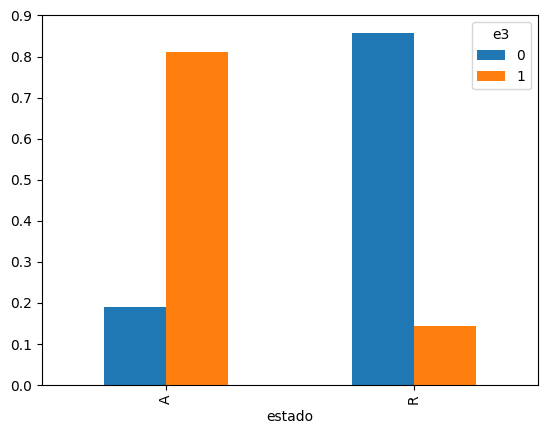

In [5]:
pd.crosstab(data["estado"],data["e3"],normalize="index").plot.bar()

<Axes: xlabel='estado'>

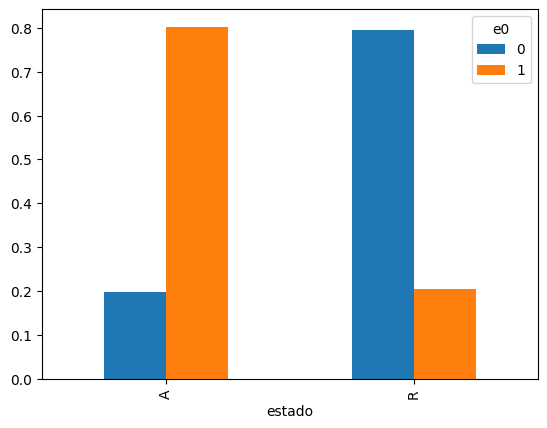

In [6]:
pd.crosstab(data["estado"],data["e0"],normalize="index").plot.bar()

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

In [8]:
Y=data["estado"].astype("category").cat.codes

In [9]:
Y.value_counts()

0    418
1     49
Name: count, dtype: int64

In [10]:
X=data[["e3","e0"]]

In [11]:
X

,e3,e0
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
462,1,1
463,1,1
464,1,1
465,1,1


In [12]:
X=X.to_numpy()
Y=Y.to_numpy()

In [13]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=1)

In [14]:
from imblearn.over_sampling import RandomOverSampler

In [15]:
np.sum(y_train)

39

In [16]:
y_train.shape

(373,)

In [17]:
os=RandomOverSampler(random_state=1)
x_train_o,y_train_o=os.fit_resample(x_train,y_train)

In [18]:
x_train_o.shape

(668, 2)

In [19]:
y_train_o.shape

(668,)

In [20]:
np.sum(y_train_o)

334

In [29]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,Input
from keras.models import Sequential
import keras_tuner
from keras_tuner.engine.hyperparameters import Choice

In [35]:
def build_model(hp):
    modelo=Sequential()
    modelo.add(Input(shape=(2,)))
    for i in range(hp.Choice("capas",[1,2,3])):
        modelo.add(Dense(hp.Choice("neuronas_capa",[8,16,32,64])))
    modelo.add(Dense(1,activation="sigmoid"))
    modelo.compile(loss="binary_crossentropy",metrics=[tf.keras.metrics.BinaryAccuracy(name="acc")])
    return modelo

In [36]:
tuner=keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_acc",direction="max"),
    max_trials=32,
    executions_per_trial=2,
    overwrite=True,
    directory="modelos",
    project_name="reprobacion"
)

In [37]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
capas (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
neuronas_capa (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64], 'ordered': True}


In [38]:
tuner.search(x_train_o,y_train_o,epochs=8,validation_data=(x_test,y_test))

Trial 12 Complete [00h 00m 03s]
val_acc: 0.8617021441459656

Best val_acc So Far: 0.8776595890522003
Total elapsed time: 00h 00m 36s


In [41]:
mejor_modelo=tuner.get_best_models()[0]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [42]:
mejor_modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257 (1.00 KB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
mejor_modelo.save("mejor_modelo.keras")

In [91]:
y_pred_probs=mejor_modelo.predict(x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


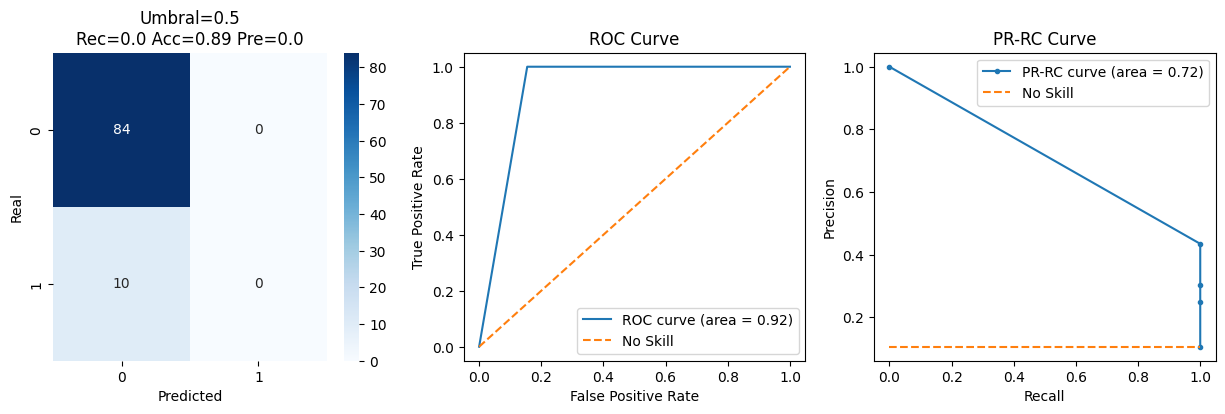

In [106]:
umbral=0.5

y_pred=y_pred_probs[:]>=umbral

fig, axes = plt.subplots(1,3)
fig.set_size_inches(15, 4)

matriz = confusion_matrix(y_test, y_pred)    
ax=axes[0]
sns.heatmap(matriz, annot=True, ax = ax, cmap="Blues",fmt="d");
ax.set_title("Umbral="+str(umbral)+"\nRec="+str(round(recall_score(y_test, y_pred),2))+
        " Acc="+str(round(accuracy_score(y_test, y_pred),2))+
        " Pre="+str(round(precision_score(y_test, y_pred),2)))
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Real')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs) 
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].plot([0, 1], [0, 1], '--', label='No Skill')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()

lr_precision, lr_recall, thresholds_pr = precision_recall_curve(y_test, y_pred_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
no_skill = len(y_test[y_test==1]) / len(y_test)
axes[2].plot(lr_recall, lr_precision, marker='.', label='PR-RC curve (area = %0.2f)' % auc(lr_recall,lr_precision))
axes[2].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('PR-RC Curve')
axes[2].legend();

In [108]:
puntos=np.where(lr_precision[:-1]>0.40)
recs=[]
thrs=[]
print(puntos)
for punto in puntos:
    rec=lr_recall[punto]
    thr=thresholds_pr[punto]
    recs.append(rec)
    thrs.append(thr)
print("recalls",recs)
print("thresholds",thrs)
print("precisions",lr_precision[puntos])

(array([3]),)
recalls [array([1.])]
thresholds [array([0.4875058], dtype=float32)]
precisions [0.43478261]


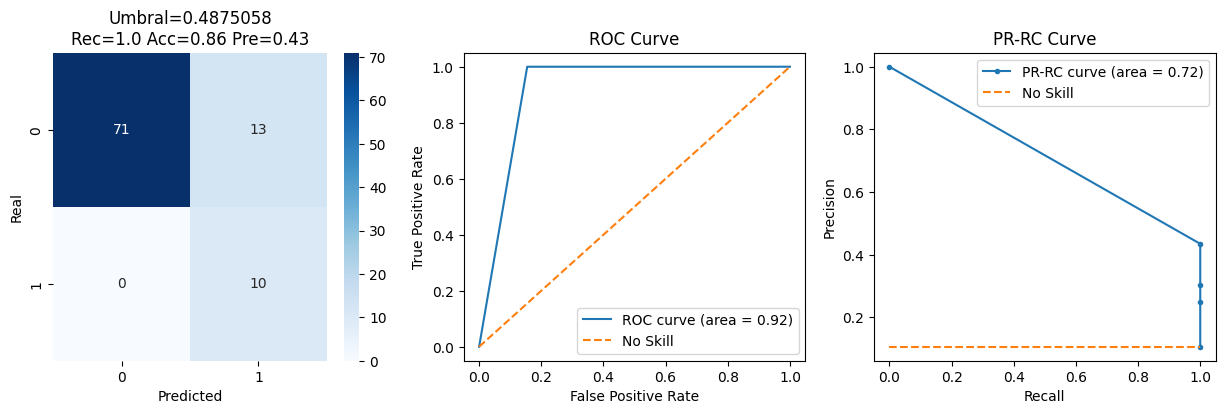

In [109]:
umbral=0.4875058

y_pred=y_pred_probs[:]>=umbral

fig, axes = plt.subplots(1,3)
fig.set_size_inches(15, 4)

matriz = confusion_matrix(y_test, y_pred)    
ax=axes[0]
sns.heatmap(matriz, annot=True, ax = ax, cmap="Blues",fmt="d");
ax.set_title("Umbral="+str(umbral)+"\nRec="+str(round(recall_score(y_test, y_pred),2))+
        " Acc="+str(round(accuracy_score(y_test, y_pred),2))+
        " Pre="+str(round(precision_score(y_test, y_pred),2)))
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Real')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs) 
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].plot([0, 1], [0, 1], '--', label='No Skill')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()

lr_precision, lr_recall, thresholds_pr = precision_recall_curve(y_test, y_pred_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
no_skill = len(y_test[y_test==1]) / len(y_test)
axes[2].plot(lr_recall, lr_precision, marker='.', label='PR-RC curve (area = %0.2f)' % auc(lr_recall,lr_precision))
axes[2].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('PR-RC Curve')
axes[2].legend();